# Figures for AGU Poster

### Load necessary packages and data:

In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
import ulmo
import datetime as dt
from datetime import datetime
#from shapely.geometry import Point
#import metloom
#from metloom.pointdata import CDECPointData
#from metloom.pointdata import SnotelPointData
#from metloom.variables import CdecStationVariables
import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd
import sklearn
from sklearn.cluster import KMeans

import rioxarray as rxr
import xarray as xr
import rasterio as rio
import matplotlib
import regionmask

In [3]:
wstates = gpd.read_file('../../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')

wstates_boundary = gpd.read_file('../../data/misc/western_boundary.geojson')
western_snotel_locations = pickle.load(open('../../data/snotel/western_snotel_locations.pkl', 'rb'))
station_locations_co = pickle.load(open('../../data/station_locations_co.pkl', 'rb'))
combined_april1_anom_co = pickle.load(open('../../data/combined_april1_anom_co.pkl', 'rb'))

### Load April 1 SWE reanalysis product from 1990 - 2021:

In [5]:
base_dir = '../../data/reanalysis/swe/' 
fname_lst = []
## create list of netcdf files ##
years = list(sorted((f for f in os.listdir(base_dir) if not f.startswith(".")), key=str.lower))
for year in years:
    yr_dir = f'{base_dir}{year}/SWE_Post/'
    fname = os.listdir(yr_dir)[0]
    fname_lst.append(f'{base_dir}{year}/SWE_Post/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SWE_Post'] = ds['SWE_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname_lst, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
ds['Year'] = np.arange(1990,2022)
ds.rio.write_crs('epsg:4326')
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [6]:
ds_coarse = ds.SWE_Post.coarsen(y=8, boundary='trim').mean()
ds_coarse_na = ds_coarse.where(ds_coarse != 0)

In [7]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

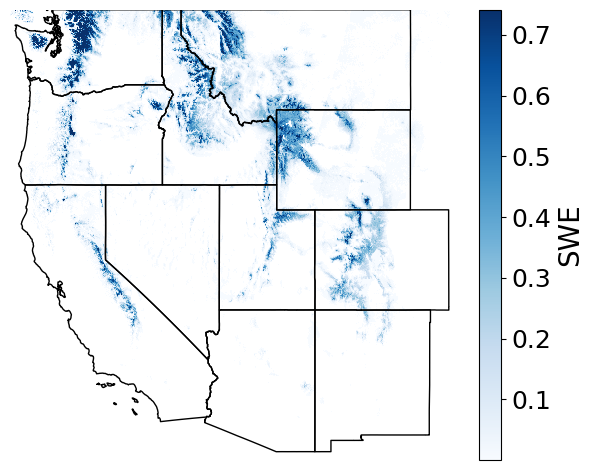

In [189]:
fig, ax=plt.subplots()
c = ds_coarse_na[0].plot(robust=True,cmap='Blues', add_colorbar=False)
wstates_4326.plot(ax=ax, facecolor='none',edgecolor='k')
plt.axis('off')
plt.title('')
cb=plt.colorbar(c,orientation='vertical').set_label(label='SWE',size=20) #,weight='bold'
c.figure.axes[1].tick_params(axis="x", labelsize=20)
plt.tight_layout()
plt.savefig('../figures/swe_example.jpeg',dpi=300)

In [8]:
mean_swe = ds.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)

In [9]:
mean_swe_coarser = mean_swe.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()

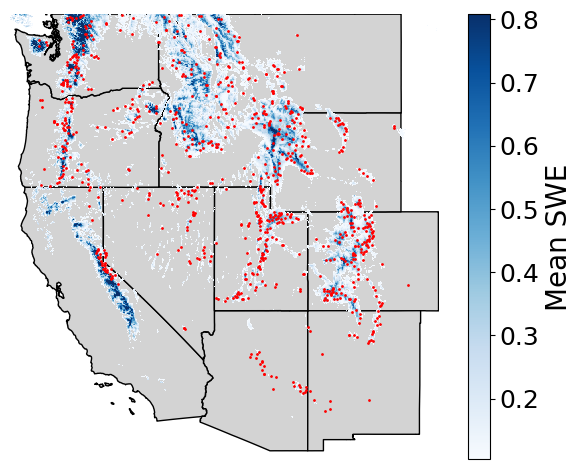

In [15]:
fig, ax=plt.subplots()
wstates_4326.plot(ax=ax, facecolor='lightgrey',edgecolor='k')
c = mean_swe_coarser.plot(robust=True, add_colorbar=False,cmap='Blues')
western_snotel_locations.plot(ax=ax, markersize = 1, color='red')
plt.axis('off')
plt.title('')
cb=plt.colorbar(c,orientation='vertical').set_label(label='Mean SWE',size=20) #"$X_{axis}$" #,weight='bold'
c.figure.axes[1].tick_params(axis="x", labelsize=20)
plt.tight_layout()
plt.savefig('../../figures/Mean_swe_w_snotel.jpeg',dpi=300)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


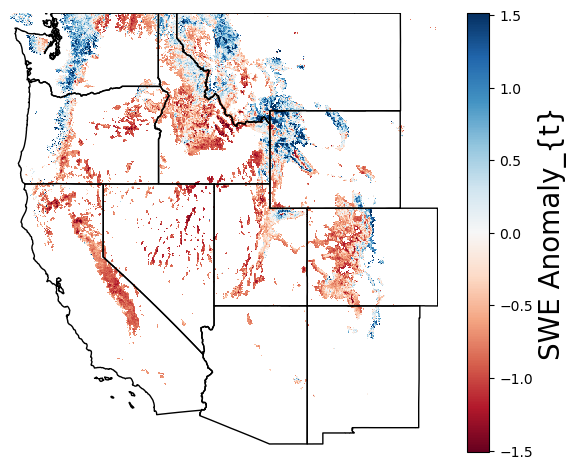

In [37]:
fig, ax=plt.subplots()
c = anomalies_sdev_coarser[0].plot(robust=True, add_colorbar=False,cmap='RdBu')
wstates_4326.plot(ax=ax, facecolor='none',edgecolor='k')
plt.axis('off')
plt.title('')
cb=plt.colorbar(c,orientation='vertical').set_label(label='$SWE Anomaly_{t}$',size=20) #"$X_{axis}$" #,weight='bold'
c.figure.axes[1].tick_params(axis="x", labelsize=20)
plt.tight_layout()
plt.savefig('../figures/swe_anomaly_example.jpeg',dpi=300)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


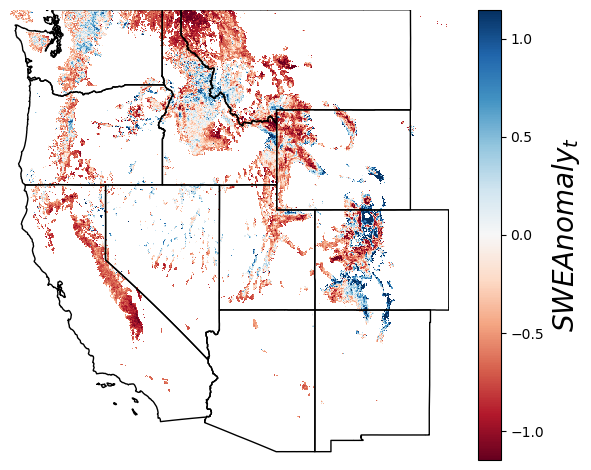

In [42]:
fig, ax=plt.subplots()
c = anomalies_sdev_coarser[-1].plot(robust=True, add_colorbar=False,cmap='RdBu')
wstates_4326.plot(ax=ax, facecolor='none',edgecolor='k')
plt.axis('off')
plt.title('')
cb=plt.colorbar(c,orientation='vertical').set_label(label='$SWE Anomaly_{t}$',size=20) #"$X_{axis}$" #,weight='bold'
c.figure.axes[1].tick_params(axis="x", labelsize=20)
plt.tight_layout()
plt.savefig('../figures/swe_anomaly_2021.jpeg',dpi=300)